In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform

## Load data

In [2]:
white_wine_path='./Data/no-duplicates-winequality-white.csv'
w_df=pd.read_csv(white_wine_path, sep=',')
w_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


### Logistic Regression

Our response variable comes from a 'quality' distribution that ranges from 0-10. In order to apply a binary Logistic regression model to this dataset, we have to bin our response variable into 'low' and 'high' quality. 

In [3]:
quality_freq=w_df['quality'].value_counts().sort_index()
quality_freq

3      20
4     153
5    1175
6    1788
7     689
8     131
9       5
Name: quality, dtype: int64

In [4]:
ranges=[0,6,10]
group_names=['low', 'high']
w_df['quality_bin']=pd.cut(w_df['quality'], bins=ranges, labels=group_names)

In [5]:
w_df['quality_bin'].value_counts().sort_index()

low     3136
high     825
Name: quality_bin, dtype: int64

We drop the alcohol column as well because it has high correlation with the density feature.

In [6]:
y=w_df['quality_bin']
X=w_df.drop(['quality', 'quality_bin','alcohol'], axis=1)

In [7]:
f1_=[]
test_acc=[]
best_score=[]
model=[]
roc=[]

In [8]:
def record_results(model_name):
    y_pred=cv.predict(X_test)
    f1_.append(f1_score(y_test,y_pred, average='macro'))
    test_acc.append(accuracy_score(y_test,y_pred))
    best_score.append(cv.best_score_)
    roc.append(auc)
    model.append(model_name)
    return None

We set up a pipeline that includes scaling the data using RobustScaler and a grid search over the the parameters penalty (lasso vs ridge regression regularization) and C (regularization strength)

In [9]:
steps=[('scaler', RobustScaler()),('LogReg', LogisticRegression(solver='liblinear'))]
pipe=Pipeline(steps)
parameters= {'LogReg__penalty': ['l1', 'l2'], 'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]}
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=GridSearchCV(pipe,param_grid=parameters,cv=kf,scoring='f1_macro')
cv.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('LogReg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'LogReg__penalty': ['l1', 'l2']},
             scoring='f1_macro')

In [10]:
cv.best_params_

{'LogReg__C': 1000.0, 'LogReg__penalty': 'l1'}

#### ROC Curve

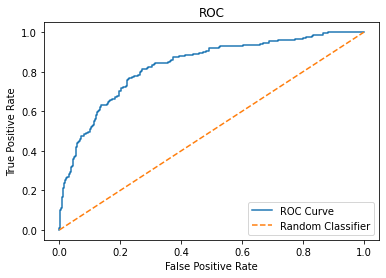

In [11]:
y_prob = cv.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='high')
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [12]:
record_results('Logistic Regression')

#### PCA with Logistic Regression

In [13]:
steps=[('scaler', RobustScaler()),('pca',PCA()),('LogReg', LogisticRegression(solver='liblinear'))]
pipe=Pipeline(steps)
parameters= {'pca__n_components':list(np.arange(1,X.shape[1]+1)),'LogReg__penalty': ['l1', 'l2'], 'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]}
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=GridSearchCV(pipe,param_grid=parameters,cv=kf,scoring='f1_macro')
cv.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('pca', PCA()),
                                       ('LogReg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'LogReg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1_macro')

In [14]:
cv.best_params_

{'LogReg__C': 1.0, 'LogReg__penalty': 'l1', 'pca__n_components': 10}

#### ROC Curve

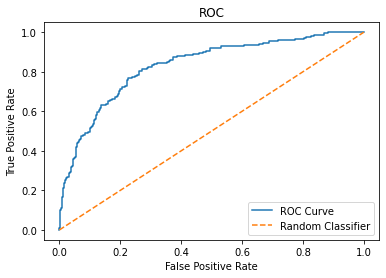

In [15]:
y_prob = cv.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='high')
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [16]:
record_results('Logistic Regression with PCA')

### Random Forest

In [17]:
num_features=X.shape[1]

In [18]:
steps=[('randomForest', RandomForestClassifier())]
pipe=Pipeline(steps)
parameters= {'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(10,100),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']}
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=RandomizedSearchCV(pipe, param_distributions=parameters, cv=kf, scoring='f1_macro', n_iter=50, random_state=123)
cv.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('randomForest',
                                              RandomForestClassifier())]),
                   n_iter=50,
                   param_distributions={'randomForest__criterion': ['gini',
                                                                    'entropy'],
                                        'randomForest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D76A3760>,
                                        'randomForest__max_features': array([...,
                                        'randomForest__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D76A3A60>,
                                        'randomForest__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D6E62850>,
                                        'randomForest__n_estimators': <scipy.s

In [19]:
cv.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 26,
 'randomForest__max_features': 8,
 'randomForest__min_samples_leaf': 1,
 'randomForest__min_samples_split': 8,
 'randomForest__n_estimators': 32}

#### ROC Curve

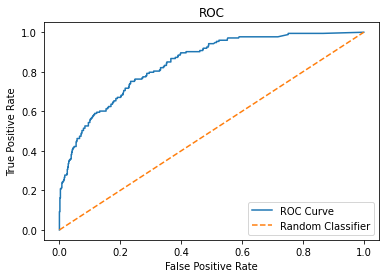

In [20]:
y_prob = cv.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='high')
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [21]:
record_results('Random Forest')

#### Gradient Boosted Trees

In [22]:
steps=[('GBT', GradientBoostingClassifier())]
pipe=Pipeline(steps)
parameters= {'GBT__learning_rate': uniform(0,100),
             'GBT__n_estimators': randint(1,1000),
             'GBT__subsample' : uniform(0,1),
             'GBT__min_samples_split': randint(2,10),
             'GBT__min_weight_fraction_leaf' : uniform(0.0,0.5),
             'GBT__max_depth' : randint(1,10),
             'GBT__max_features' : np.arange(num_features)+1,
             'GBT__min_samples_leaf': randint(1,10),
            }
kf=KFold(n_splits=5, shuffle=True, random_state=123)
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=.2,random_state=123)
cv=RandomizedSearchCV(pipe, param_distributions=parameters, cv=kf, scoring='f1_macro', n_iter=50, random_state=123)
cv.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('GBT',
                                              GradientBoostingClassifier())]),
                   n_iter=50,
                   param_distributions={'GBT__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D769DCA0>,
                                        'GBT__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D6F9DD60>,
                                        'G...
                                        'GBT__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D76A8D00>,
                                        'GBT__min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D769DE50>,
                                        'GBT__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000242D6F9D790>,
                   

In [23]:
cv.best_params_

{'GBT__learning_rate': 8.482227744523364,
 'GBT__max_depth': 3,
 'GBT__max_features': 8,
 'GBT__min_samples_leaf': 8,
 'GBT__min_samples_split': 3,
 'GBT__min_weight_fraction_leaf': 0.11273168015297996,
 'GBT__n_estimators': 494,
 'GBT__subsample': 0.28141752377861584}

#### ROC Curve

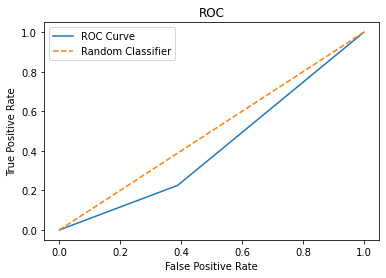

In [24]:
y_prob = cv.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='high')
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [25]:
record_results('Gradient Boosted Trees')

In [26]:
data = {'f1_test': f1_,
        'best training f1': best_score,
        'Test Accuracy': test_acc,
        'ROC' : roc}

In [27]:
pd.DataFrame(data, index=model)

,f1_test,best training f1,Test Accuracy,ROC
Logistic Regression,0.667990,0.637374,0.819672,0.168805
Logistic Regression with PCA,0.664615,0.637408,0.818411,0.168646
Random Forest,0.711248,0.687060,0.837327,0.157398
Gradient Boosted Trees,0.420603,0.517101,0.527112,0.581638


### Conclusion

Out of our 3 models: logistic regression, random forest, and gradient boosted trees, it seems like random forest performs the best.

In [28]:
#stratify?